<a href="https://colab.research.google.com/github/emm-gl/machine-learning-portfolio/blob/main/02_Generative_AI/00_conditional_probability_for_word_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative (dumb) Text Models

Emmanuel Gonzalez

August 2025

In this notebook, we will use the concepts of (conditional) probability and n-grams to generate text (similar to how ChatGPT or Gemini does it).

In [12]:
# Libraries to use:
from collections import Counter, defaultdict

import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests

np.random.seed(1)

## Loading text:
### Book: The Sun Also Rises by Ernest Hemingway

"The Sun Also Rises" by Ernest Hemingway is a novel written in the late 1920s. The book explores the lives of a group of American and British expatriates in Europe after World War I, focusing on their disillusionment and aimlessness. The central character, Jake Barnes, narrates the story, primarily revolving around his unrequited love for Lady Brett Ashley and the complex relationships within their circle of friends."

In [16]:
response = requests.get("https://www.gutenberg.org/cache/epub/67138/pg67138.txt")
libro = response.text.lower()
libro = re.sub('[^ña-z]+', ' ', libro)

print(libro[5_720:6_000])

cohn could write they came to europe where the lady had been educated and stayed three years during these three years the first spent in travel the last two in paris robert cohn had two friends braddocks and myself braddocks was his literary friend i was his tennis friend the lad


## Empirical distribution of words

In [18]:
frecuencias_palabras = Counter(libro.split())

print('Unique words: ', len(frecuencias_palabras))
frecuencias_palabras.most_common(10)

Unique words:  5113


[('the', 4693),
 ('and', 2363),
 ('i', 2335),
 ('to', 1674),
 ('a', 1593),
 ('you', 1254),
 ('of', 1250),
 ('it', 1171),
 ('was', 1168),
 ('in', 1104)]

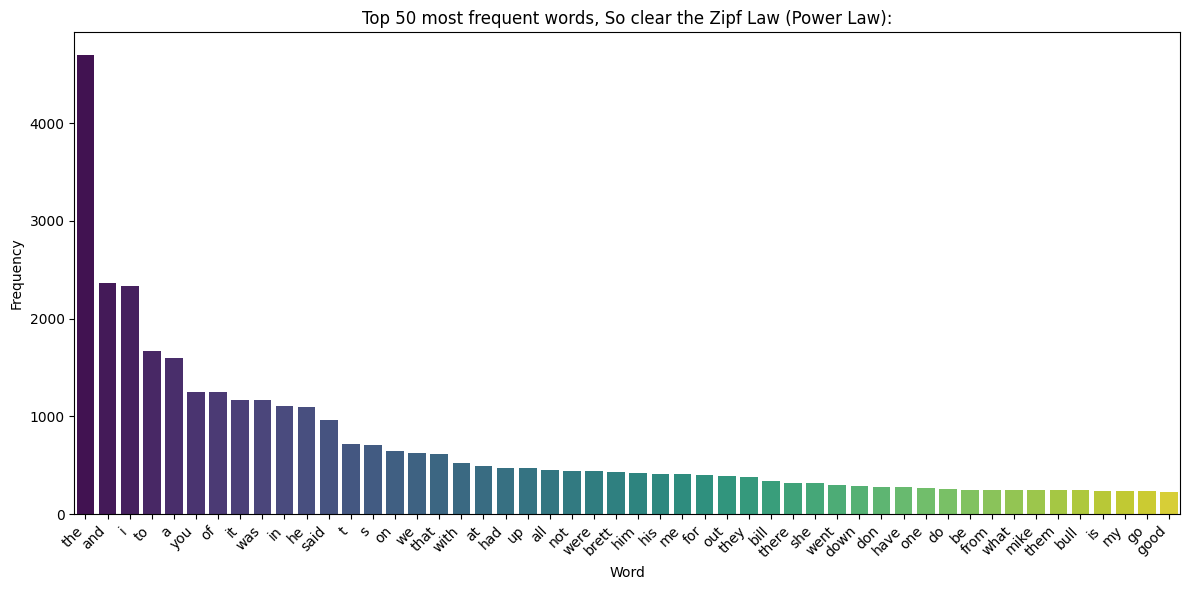

In [19]:
# Get the "n" most frequent words:
n = 50
palabras_mas_comunes = frecuencias_palabras.most_common(n)
vocabulario, frecuencias = zip(*palabras_mas_comunes)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=list(vocabulario), y=list(frecuencias), palette='viridis', hue=list(vocabulario), legend=False)
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {n} most frequent words, So clear the Zipf Law (Power Law):")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

NOTE: The relevancy/importance of a word is inversely proportional to its frequency.

i.e. As much unique a word is, more information give us.

## N-grams and Empirical Distributions

n-grams are sequences of $n$ consecutive elements (such as words or characters) in a text, and they allow us to capture local patterns. For example:

("Hello") is a 1-gram

("Hello", "how") is a bigram or 2-gram

("Hello", "how", "are") is a trigram or 3-gram

The empirical probability of a word $w$ is estimated as:

$$
P(w) \approx \frac{\text{count}(w)}{\text{total number of words}}
$$

The conditional probability of a word $w_2$ given that it was preceded by $w_1$ is estimated as:

$$
P(w_2 \mid w_1) \approx \frac{\text{count}(w_1, w_2)}{\text{count}(w_1)}
$$

and so on.


In [20]:
def genera_distribucion_condicional(lista_de_palabras, n):
    # Dictionary saves for each n-gram the most probable words that follows
    dic_ngramas = defaultdict(list) # {'I am': [Pedro, the, sorry, ...]}

    for i in range(len(lista_de_palabras) - n):
        ngrama = ' '.join(lista_de_palabras[i : i + n])
        dic_ngramas[ngrama].append(lista_de_palabras[i + n])

    return dic_ngramas

In [21]:
def genera_texto(distribucion_condicional, longitud=20):
    # First, we choose an n-gram randomly
    ngrama = np.random.choice(list(distribucion_condicional.keys()))
    texto = ngrama
    n = len(ngrama.split())

    for _ in range(longitud):
        if ngrama not in distribucion_condicional.keys():
            break
        #It's choosen one word of the probable word's list after the n-gram
        siguiente_palabra = np.random.choice(distribucion_condicional[ngrama])
        texto += ' ' + siguiente_palabra
        # Cambiamos de distribución según el último ngrama
        palabras = texto.split()
        ngrama = ' '.join(palabras[len(palabras) - n : len(palabras)])

    return texto


These elements allow us to build a generative model from a corpus.

We approximate the conditional probability:
$$P(\text{$word$} | w_1, w_2, \dots, w_n)$$
thorough the dictionary:

`{"w_1 w_2 ... w_n: [word_1, ..., word_m]}`

## Generative Text

### Sampling from the empirical distribution

In [22]:
' '.join(np.random.choice(vocabulario, 20))  # Uniform distribution

'have mike t was in said you we the that and t it bull of him up have at up'

### how to generate text with bi-grams

1. Start with an initial word, for example, "the".

2. Use the empirical distribution $P(w_2 \mid w_1 = \text{"the"})$ to **sample the next word**.

3. Take the generated word and repeat the process: sample $P(w_3 \mid w_2)$ using the newly obtained word as context.


In [23]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 1)

In [24]:
genera_texto(dist_empirica)

'certainly like that way back we all right it simple in the norte station and charged and put my nose at'

### Con trigramas

The conditional probability of the word $w_3$ given the previous pair of words $(w_1, w_2)$ is estimated as:

$$
P(w_3 \mid w_1, w_2) \approx \frac{\text{count}(w_1, w_2, w_3)}{\text{count}(w_1, w_2)}
$$

**Steps to generate text using trigrams:**

1. Start with two initial words, for example, $w_1$ and $w_2$.

2. Sample the next word $w_3$ according to the distribution $P(w_3 \mid w_1, w_2)$.

3. Repeat the process using the last two generated words as the new context: $(w_2, w_3)$, and so on.


In [25]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 2)

In [26]:
genera_texto(dist_empirica)

'with general grant so was michael they were all quite drunk my dear poor frances has had a farm a wife and'

### and so on for n-grams

In [28]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 3)

In [29]:
genera_texto(dist_empirica)

'romero they won t take a fly i ll just flick it around bill was down below watching the stream say he called'

### ¿What happen if $n \rightarrow \infty$?

In [30]:
dist_empirica = genera_distribucion_condicional(lista_de_palabras=libro.split(),
                                                n = 100)
genera_texto(dist_empirica)

'our biggest business men have been dreamers look at ford look at president coolidge look at rockefeller look at jo davidson i disjointed my rod and bill s and packed them in the rod case i put the reels in the tackle bag bill had packed the rucksack and we put one of the trout bags in i carried the other well said bill have we got everything the worms your worms put them in there he had the pack on his back and i put the worm cans in one of the outside flap pockets you got everything now i looked around on the grass at the foot of the elm trees yes we started up the road into'

As large $n$ we have the text will be the complete corpus